## Setup

In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

# Setting random seed to obtain reproducible results.
import tensorflow as tf

tf.random.set_seed(42)

import keras
from keras import layers

import os
import glob
import imageio.v2 as imageio
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# Initialize global variables.
AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 5
NUM_SAMPLES = 32
POS_ENCODE_DIMS = 10
EPOCHS = 20

In [2]:
# Download the data if it does not already exist.
url = (
    "http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz"
)
data = keras.utils.get_file(origin=url)

data = np.load(data)
images = data["images"]
im_shape = images.shape
(num_images, H, W, _) = images.shape
(poses, focal) = (data["poses"], data["focal"])

# Plot a random image from the dataset for visualization.
# plt.imshow(images[np.random.randint(low=0, high=num_images)])
# plt.show()

12727482/12727482 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
dirs = np.stack([np.sum([0, 0, -1] * pose[:3, :3], axis=-1) for pose in poses])
origins = poses[:, :3, -1]

ax = plt.figure(figsize=(12, 8)).add_subplot(projection='3d')
_ = ax.quiver(
  origins[..., 0].flatten(),
  origins[..., 1].flatten(),
  origins[..., 2].flatten(),
  dirs[..., 0].flatten(),
  dirs[..., 1].flatten(),
  dirs[..., 2].flatten(), length=0.5, normalize=True)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('z')
plt.show()

In [3]:

def encode_position(x):
    """Encodes the position into its corresponding Fourier feature.

    Args:
        x: The input coordinate.

    Returns:
        Fourier features tensors of the position.
    """
    positions = [x]
    for i in range(POS_ENCODE_DIMS):
        for fn in [tf.sin, tf.cos]:
            positions.append(fn(2.0**i * x))
    return tf.concat(positions, axis=-1)


def get_rays(height, width, focal, pose):
    """Computes origin point and direction vector of rays.

    Args:
        height: Height of the image.
        width: Width of the image.
        focal: The focal length between the images and the camera.
        pose: The pose matrix of the camera.

    Returns:
        Tuple of origin point and direction vector for rays.
    """
    # Build a meshgrid for the rays.
    i, j = tf.meshgrid(
        tf.range(width, dtype=tf.float32),
        tf.range(height, dtype=tf.float32),
        indexing="xy",
    )

    # Normalize the x axis coordinates.
    transformed_i = (i - width * 0.5) / focal

    # Normalize the y axis coordinates.
    transformed_j = (j - height * 0.5) / focal

    # Create the direction unit vectors.
    directions = tf.stack([transformed_i, -transformed_j, -tf.ones_like(i)], axis=-1)

    # Get the camera matrix.
    camera_matrix = pose[:3, :3]
    height_width_focal = pose[:3, -1]

    # Get origins and directions for the rays.
    transformed_dirs = directions[..., None, :]
    camera_dirs = transformed_dirs * camera_matrix
    ray_directions = tf.reduce_sum(camera_dirs, axis=-1)
    ray_origins = tf.broadcast_to(height_width_focal, tf.shape(ray_directions))

    # Return the origins and directions.
    print(ray_origins.shape, ray_directions.shape)
    return (ray_origins, ray_directions)


def render_flat_rays(ray_origins, ray_directions, near, far, num_samples, rand=False):
    """Renders the rays and flattens it.

    Args:
        ray_origins: The origin points for rays.
        ray_directions: The direction unit vectors for the rays.
        near: The near bound of the volumetric scene.
        far: The far bound of the volumetric scene.
        num_samples: Number of sample points in a ray.
        rand: Choice for randomising the sampling strategy.

    Returns:
       Tuple of flattened rays and sample points on each rays.
    """
    # Compute 3D query points.
    # Equation: r(t) = o+td -> Building the "t" here.
    t_vals = tf.linspace(near, far, num_samples)
    if rand:
        # Inject uniform noise into sample space to make the sampling
        # continuous.
        shape = list(ray_origins.shape[:-1]) + [num_samples]
        noise = tf.random.uniform(shape=shape) * (far - near) / num_samples
        t_vals = t_vals + noise

    # Equation: r(t) = o + td -> Building the "r" here.
    rays = ray_origins[..., None, :] + (
        ray_directions[..., None, :] * t_vals[..., None]
    )
    print(f'rays shape before reshape : {rays.shape}')
    rays_flat = tf.reshape(rays, [-1, 3])
    print(f'rays shape after reshape : {rays_flat.shape}')
    rays_flat = encode_position(rays_flat)
    print(f'rays shape after pos encode : {rays_flat.shape}')
    return (rays_flat, t_vals)


def map_fn(pose):
    """Maps individual pose to flattened rays and sample points."""
    (ray_origins, ray_directions) = get_rays(height=H, width=W, focal=focal, pose=pose)
    (rays_flat, t_vals) = render_flat_rays(ray_origins=ray_origins, ray_directions=ray_directions,
                                           near=2.0, far=6.0, num_samples=NUM_SAMPLES, rand=True)

    ray_directions = ray_directions[..., None, :]
    print(ray_directions.shape)
    ray_directions_flat = tf.reshape(ray_directions, [-1, 3])
    print(ray_directions_flat.shape)

    encoded_ray_directions = encode_position(ray_directions_flat)

    print("Encoded ray directions shape:", encoded_ray_directions.shape)

    # 샘플당 하나의 방향 벡터가 필요하므로, NUM_SAMPLES 만큼 각 방향 벡터를 반복
    repeated_encoded_ray_directions = tf.repeat(encoded_ray_directions, repeats=NUM_SAMPLES, axis=0)

    # 최종 형태 확인
    print("Repeated encoded ray directions shape:", repeated_encoded_ray_directions.shape)
    ray_directions = repeated_encoded_ray_directions
    return (rays_flat, ray_directions, t_vals)





# Create the training split.
split_index = int(num_images * 0.8)

# Split the images into training and validation.
train_images = images[:split_index]
val_images = images[split_index:]

# Split the poses into training and validation.
train_poses = poses[:split_index]
val_poses = poses[split_index:]

# Make the training pipeline.
train_img_ds = tf.data.Dataset.from_tensor_slices(train_images)
train_pose_ds = tf.data.Dataset.from_tensor_slices(train_poses)
train_ray_ds = train_pose_ds.map(map_fn, num_parallel_calls=AUTO)
training_ds = tf.data.Dataset.zip((train_img_ds, train_ray_ds))
train_ds = (
    training_ds.shuffle(BATCH_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True, num_parallel_calls=AUTO)
    .prefetch(AUTO)
)

# Make the validation pipeline.
val_img_ds = tf.data.Dataset.from_tensor_slices(val_images)
val_pose_ds = tf.data.Dataset.from_tensor_slices(val_poses)
val_ray_ds = val_pose_ds.map(map_fn, num_parallel_calls=AUTO)
validation_ds = tf.data.Dataset.zip((val_img_ds, val_ray_ds))
val_ds = (
    validation_ds.shuffle(BATCH_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True, num_parallel_calls=AUTO)
    .prefetch(AUTO)
)

(100, 100, 3) (100, 100, 3)
rays shape before reshape : (100, 100, 32, 3)
rays shape after reshape : (320000, 3)
rays shape after pos encode : (320000, 63)
(100, 100, 1, 3)
(10000, 3)
Encoded ray directions shape: (10000, 63)
Repeated encoded ray directions shape: (320000, 63)
(100, 100, 3) (100, 100, 3)
rays shape before reshape : (100, 100, 32, 3)
rays shape after reshape : (320000, 3)
rays shape after pos encode : (320000, 63)
(100, 100, 1, 3)
(10000, 3)
Encoded ray directions shape: (10000, 63)
Repeated encoded ray directions shape: (320000, 63)


In [4]:
def get_nerf_model(num_layers, num_pos):
    inputs_pos = keras.Input(shape=(num_pos, 2 * 3 * POS_ENCODE_DIMS + 3))
    inputs_dir = keras.Input(shape=(num_pos, 2 * 3 * POS_ENCODE_DIMS + 3))

    x = inputs_pos
    for i in range(num_layers):
        x = layers.Dense(units=64, activation="relu")(x)
        if i == 3 and i > 0:
            x = layers.concatenate([x, inputs_pos], axis=-1)

    alpha = layers.Dense(units=1)(x)

    bottleneck = layers.Dense(units=64, activation="relu")(x)

    input_viewdirs = layers.Concatenate(axis=-1)([bottleneck, inputs_dir])
    outputs = layers.Dense(units=32, activation="relu")(input_viewdirs) # bottleneck
    rgb = layers.Dense(units=3, activation=None)(outputs)
    outputs = layers.Concatenate(axis=-1)([rgb, alpha])  # Alpha

    return keras.Model(inputs=[inputs_pos, inputs_dir], outputs=outputs)

def render_rgb_depth(model, rays_flat, rays_dirs, t_vals, rand=True, train=True):
    """Generates the RGB image and depth map from model prediction.

    Args:
        model: The MLP model that is trained to predict the rgb and
            volume density of the volumetric scene.
        rays_flat: The flattened rays that serve as the input to
            the NeRF model.
        t_vals: The sample points for the rays.
        rand: Choice to randomise the sampling strategy.
        train: Whether the model is in the training or testing phase.

    Returns:
        Tuple of rgb image and depth map.
    """
    # Get the predictions from the nerf model and reshape it.
    if train:
        predictions = model([rays_flat, rays_dirs])
    else:
        predictions = model.predict([rays_flat, rays_dirs])
    predictions = tf.reshape(predictions, shape=(BATCH_SIZE, H, W, NUM_SAMPLES, 4))

    # Slice the predictions into rgb and sigma.
    rgb = tf.sigmoid(predictions[..., :-1])
    sigma_a = tf.nn.relu(predictions[..., -1])

    # Get the distance of adjacent intervals.
    delta = t_vals[..., 1:] - t_vals[..., :-1]
    # delta shape = (num_samples)
    if rand:
        delta = tf.concat(
            [delta, tf.broadcast_to([1e10], shape=(BATCH_SIZE, H, W, 1))], axis=-1
        )
        alpha = 1.0 - tf.exp(-sigma_a * delta)
    else:
        delta = tf.concat(
            [delta, tf.broadcast_to([1e10], shape=(BATCH_SIZE, 1))], axis=-1
        )
        alpha = 1.0 - tf.exp(-sigma_a * delta[:, None, None, :])

    # Get transmittance.
    exp_term = 1.0 - alpha
    epsilon = 1e-10
    transmittance = tf.math.cumprod(exp_term + epsilon, axis=-1, exclusive=True)
    weights = alpha * transmittance
    rgb = tf.reduce_sum(weights[..., None] * rgb, axis=-2)

    if rand:
        depth_map = tf.reduce_sum(weights * t_vals, axis=-1)
    else:
        depth_map = tf.reduce_sum(weights * t_vals[:, None, None], axis=-1)
    return (rgb, depth_map)


Epoch 1/20
(5, 320000, 63)
(5, 320000, 63)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


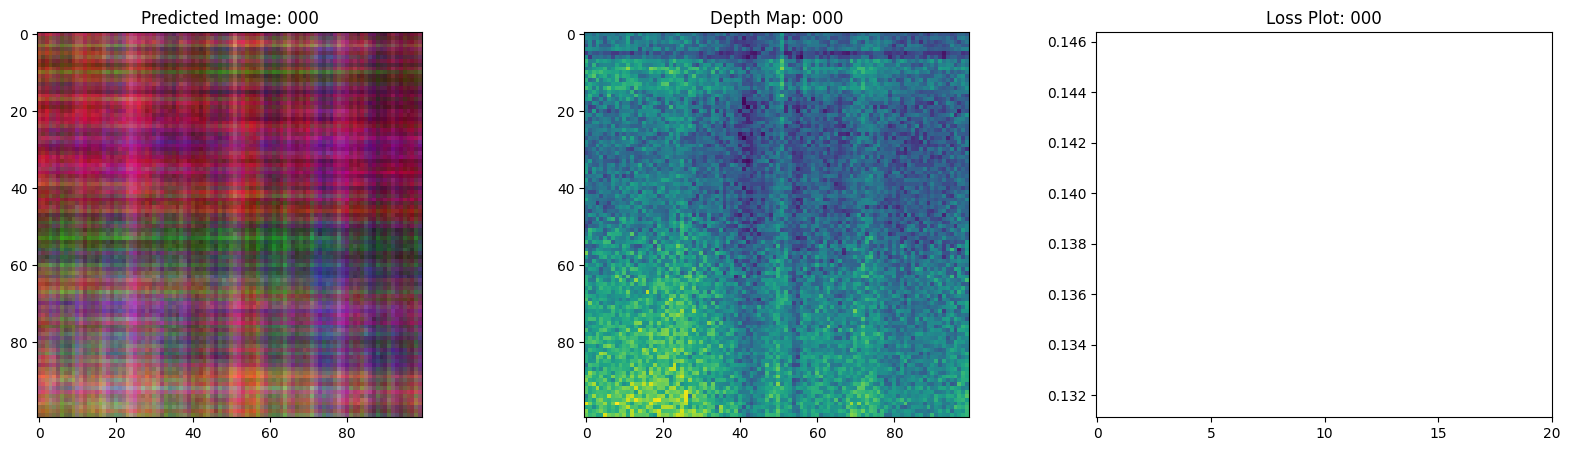

16/16 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - loss: 0.1400 - psnr: 8.7493 - val_loss: 0.0856 - val_psnr: 10.8092
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 924ms/step


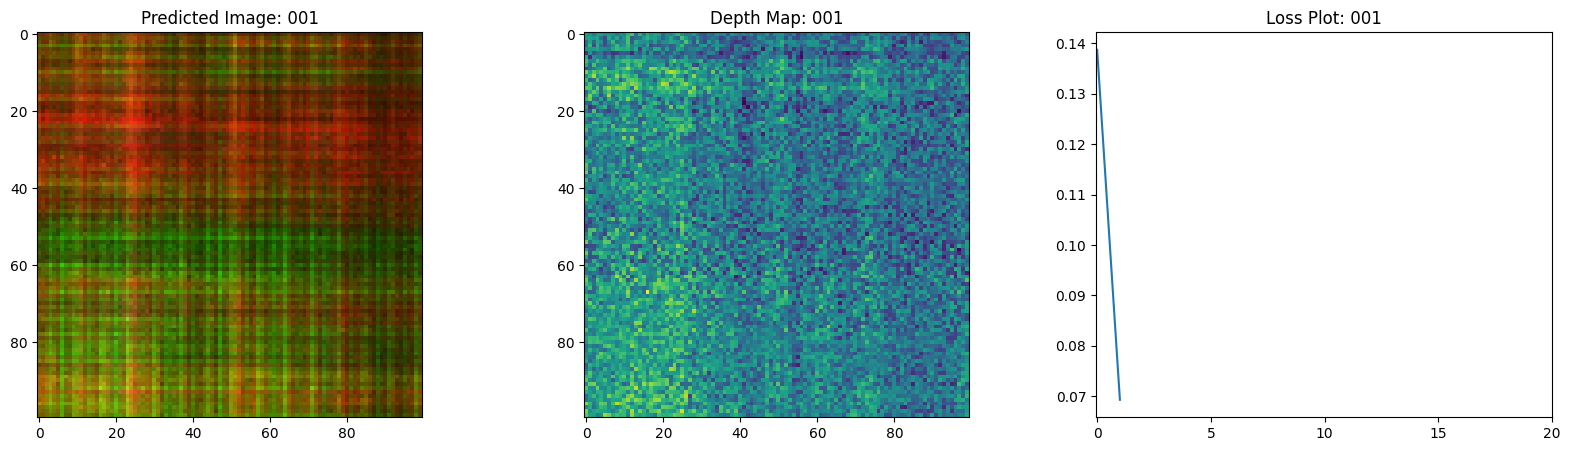

16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - loss: 0.0701 - psnr: 11.8868 - val_loss: 0.0717 - val_psnr: 11.8390
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step


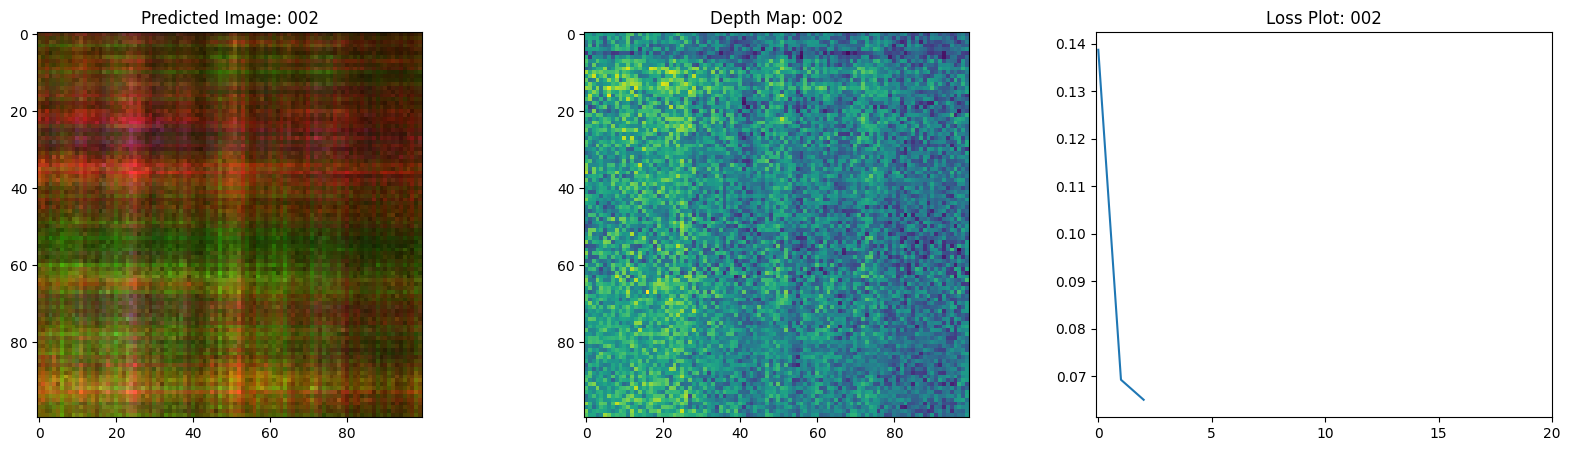

16/16 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - loss: 0.0634 - psnr: 12.3143 - val_loss: 0.0702 - val_psnr: 11.9799
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step


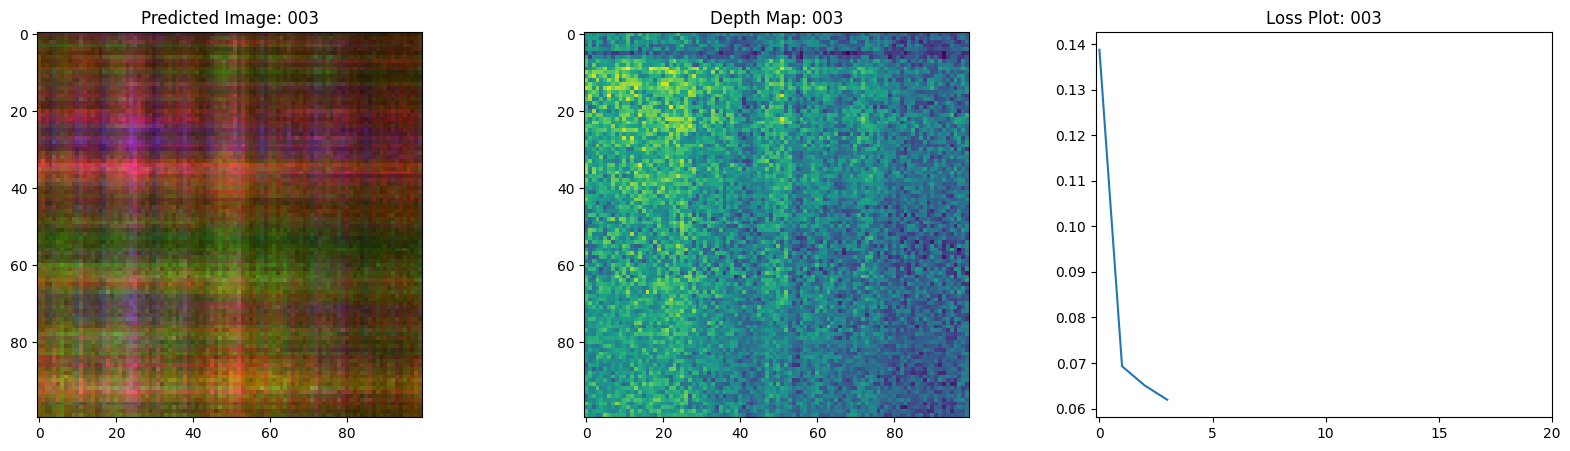

16/16 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - loss: 0.0605 - psnr: 12.5589 - val_loss: 0.0681 - val_psnr: 12.0645
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step


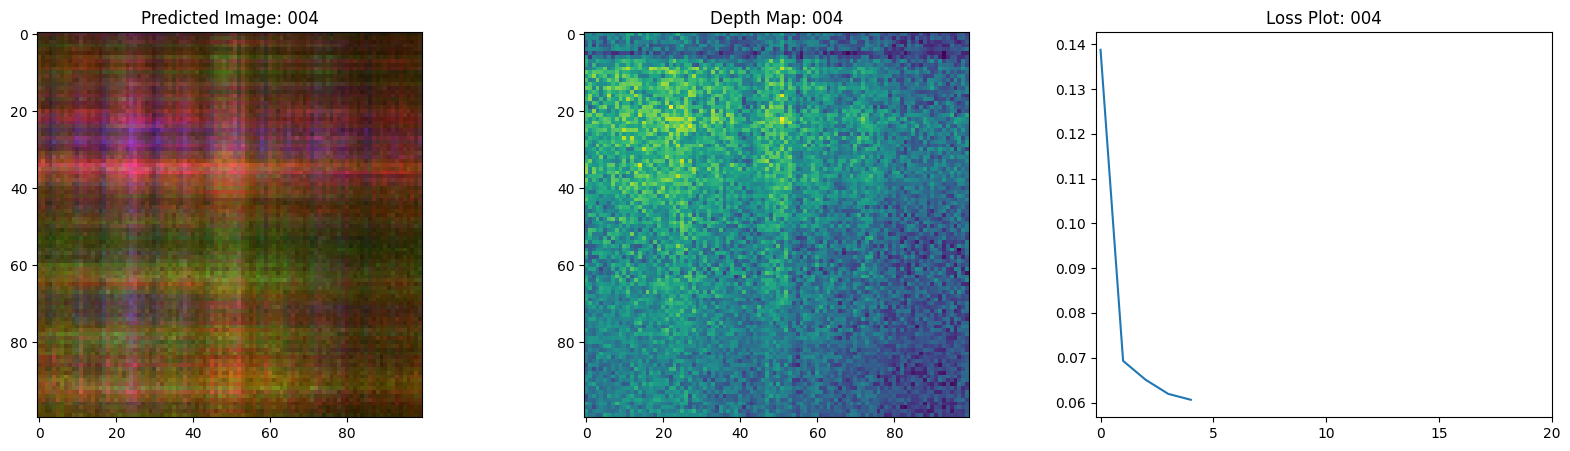

16/16 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - loss: 0.0593 - psnr: 12.6633 - val_loss: 0.0659 - val_psnr: 12.2390
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/step


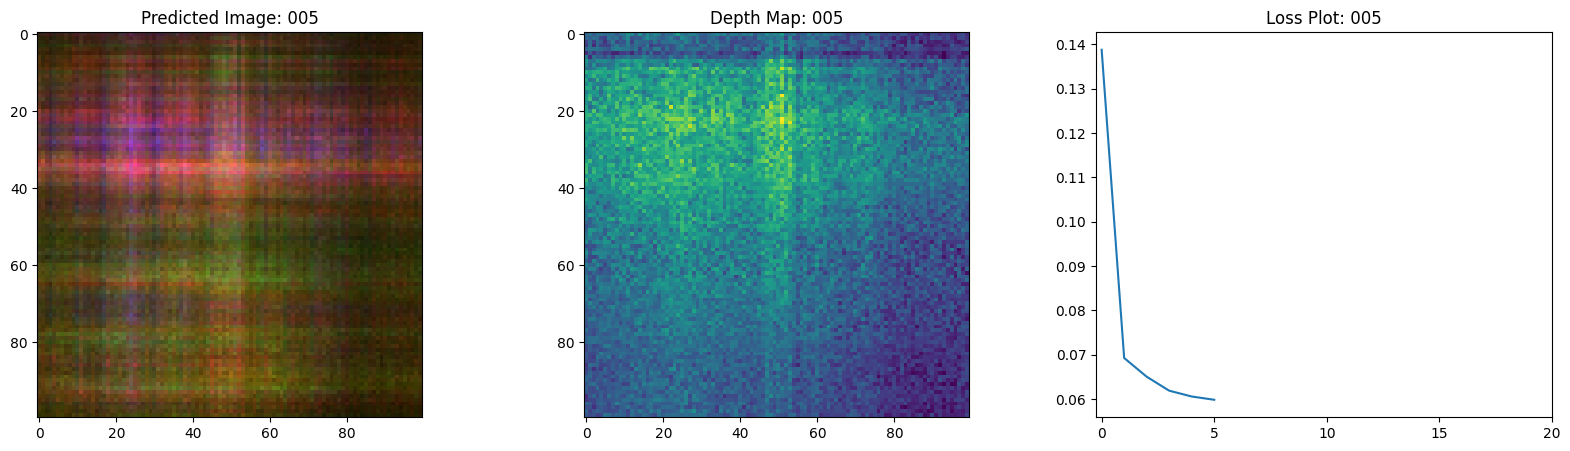

16/16 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - loss: 0.0593 - psnr: 12.6460 - val_loss: 0.0651 - val_psnr: 12.2741
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step


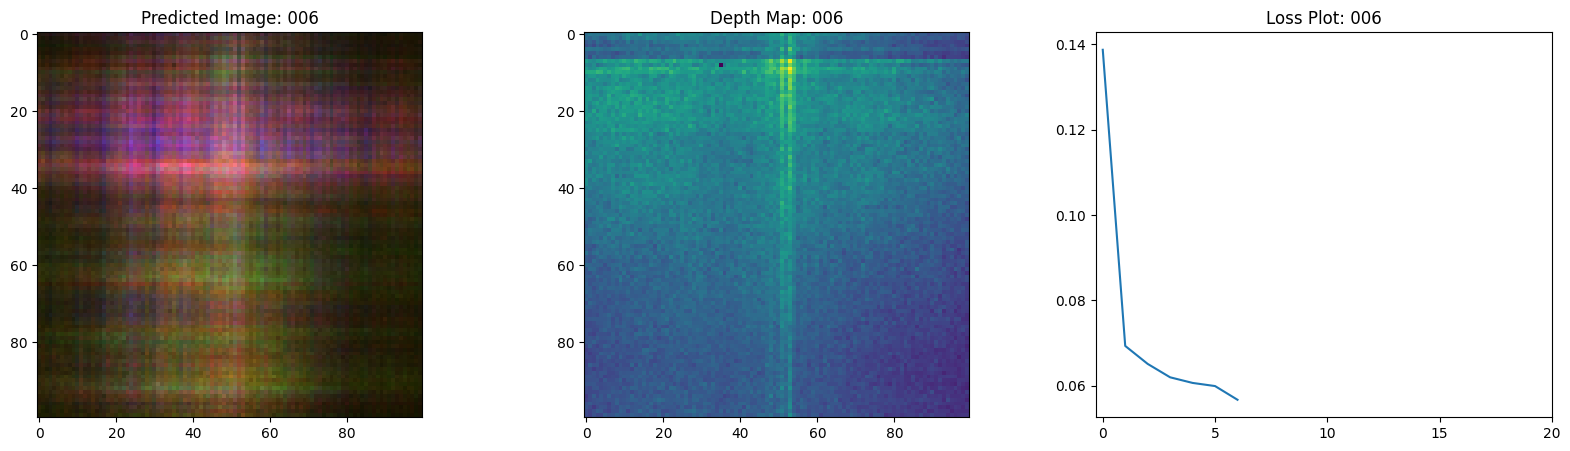

16/16 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - loss: 0.0575 - psnr: 12.7968 - val_loss: 0.0635 - val_psnr: 12.3605
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 699ms/step


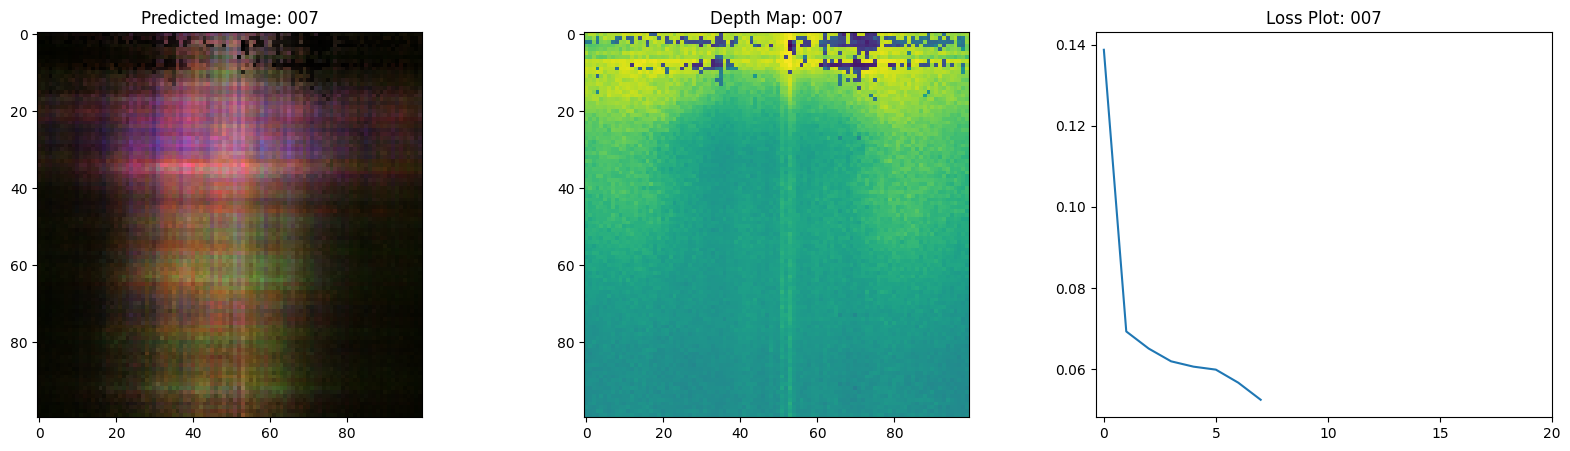

16/16 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - loss: 0.0538 - psnr: 13.1003 - val_loss: 0.0530 - val_psnr: 13.0381
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 725ms/step


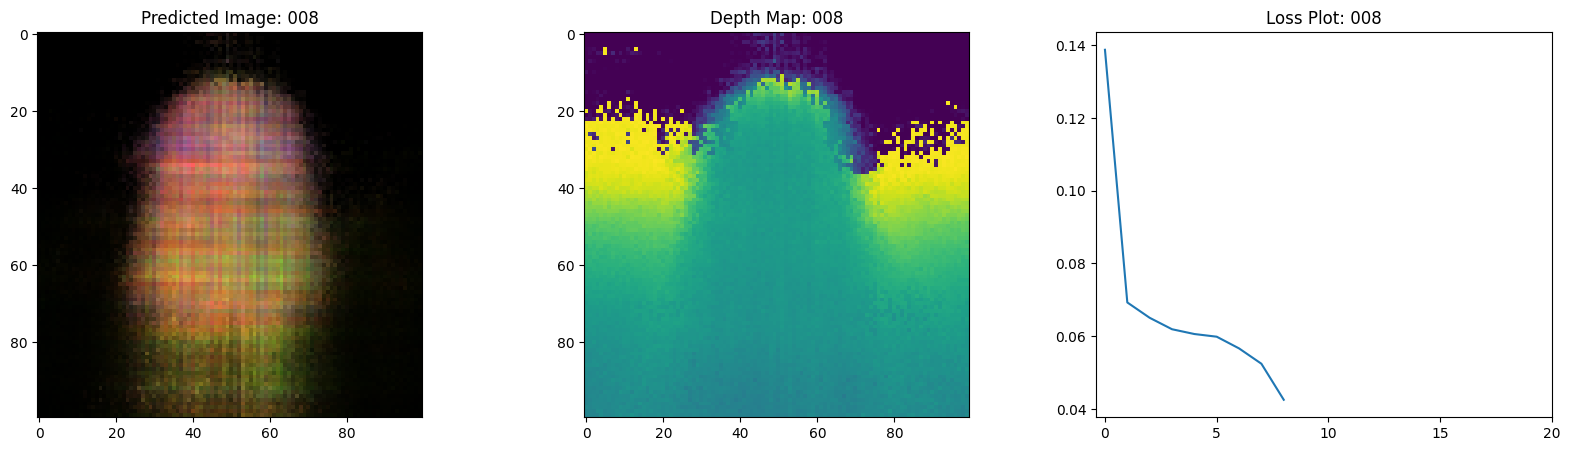

16/16 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - loss: 0.0450 - psnr: 13.8507 - val_loss: 0.0371 - val_psnr: 14.5682
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 693ms/step


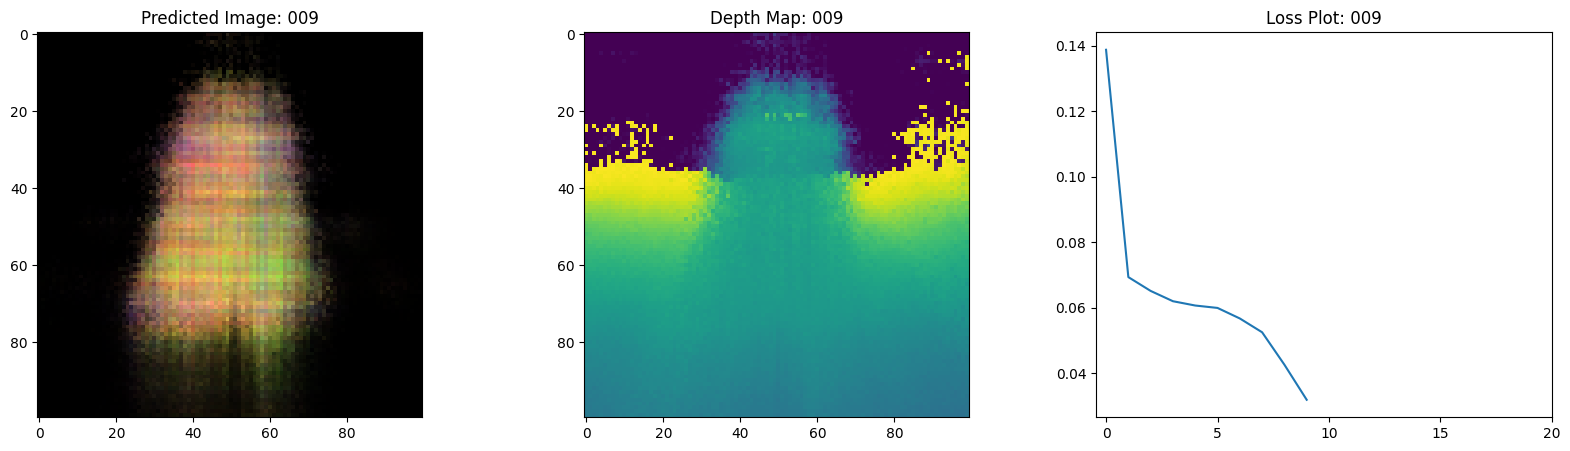

16/16 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - loss: 0.0325 - psnr: 15.1562 - val_loss: 0.0313 - val_psnr: 15.1827
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 686ms/step


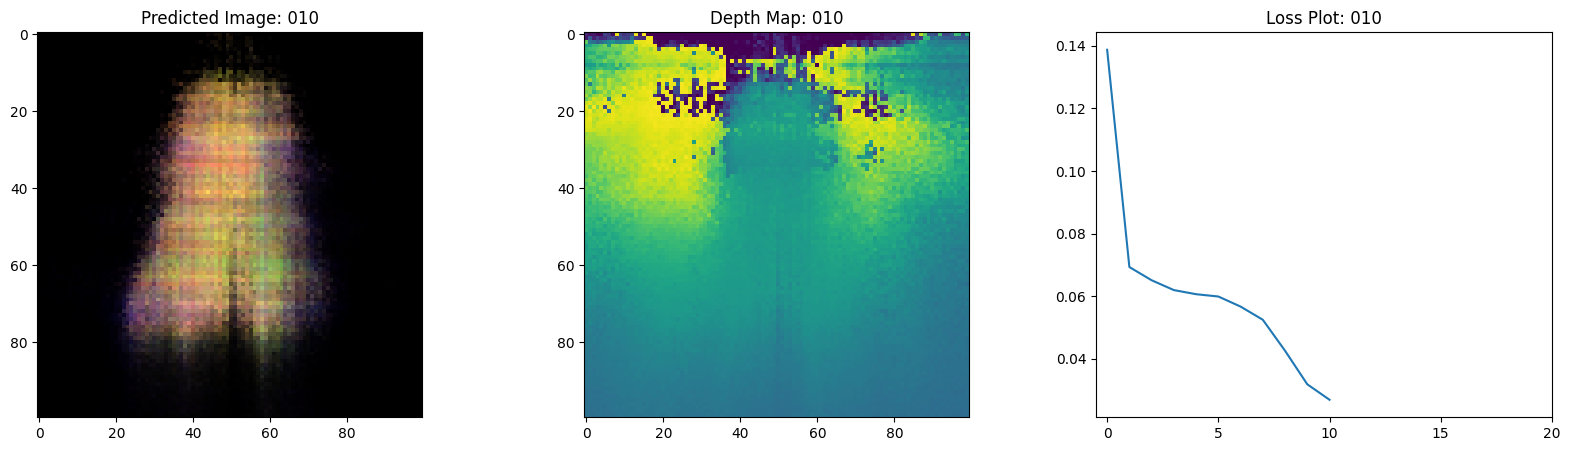

16/16 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - loss: 0.0272 - psnr: 15.8860 - val_loss: 0.0277 - val_psnr: 15.7539
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 691ms/step


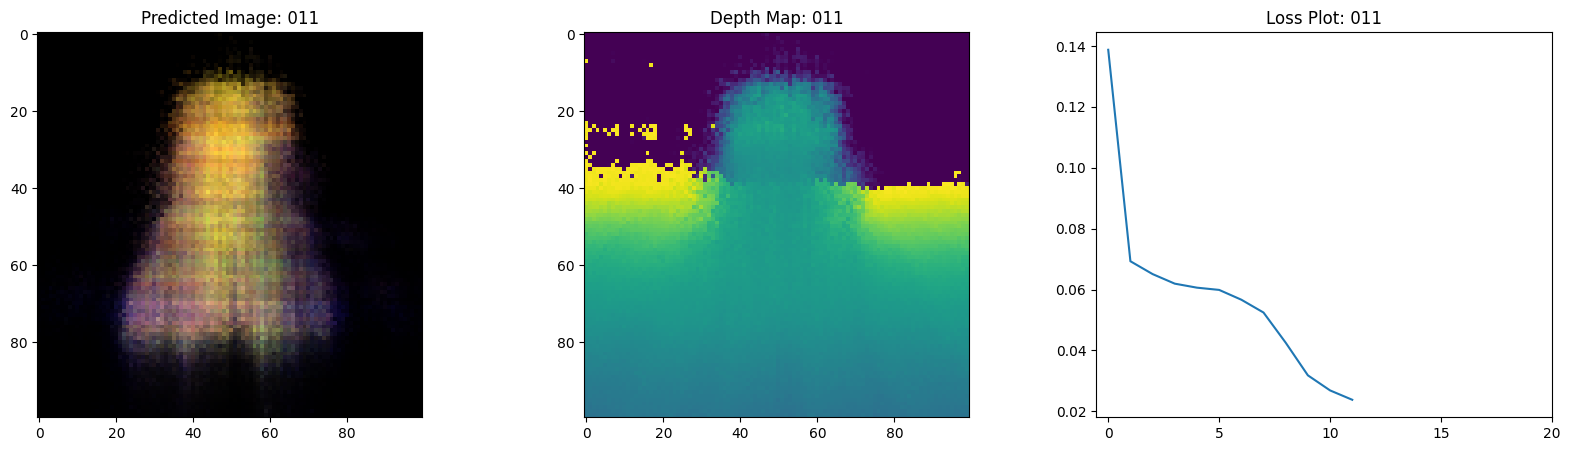

16/16 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - loss: 0.0246 - psnr: 16.3018 - val_loss: 0.0222 - val_psnr: 16.6732
Epoch 13/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 720ms/step


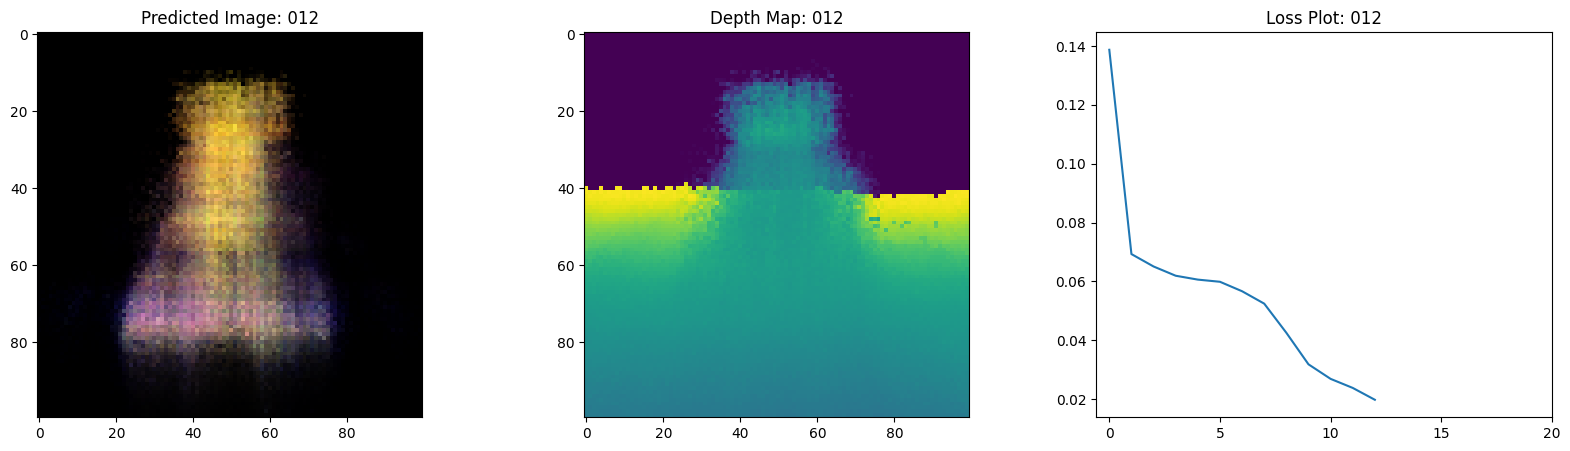

16/16 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - loss: 0.0208 - psnr: 17.0392 - val_loss: 0.0179 - val_psnr: 17.6423
Epoch 14/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 945ms/step


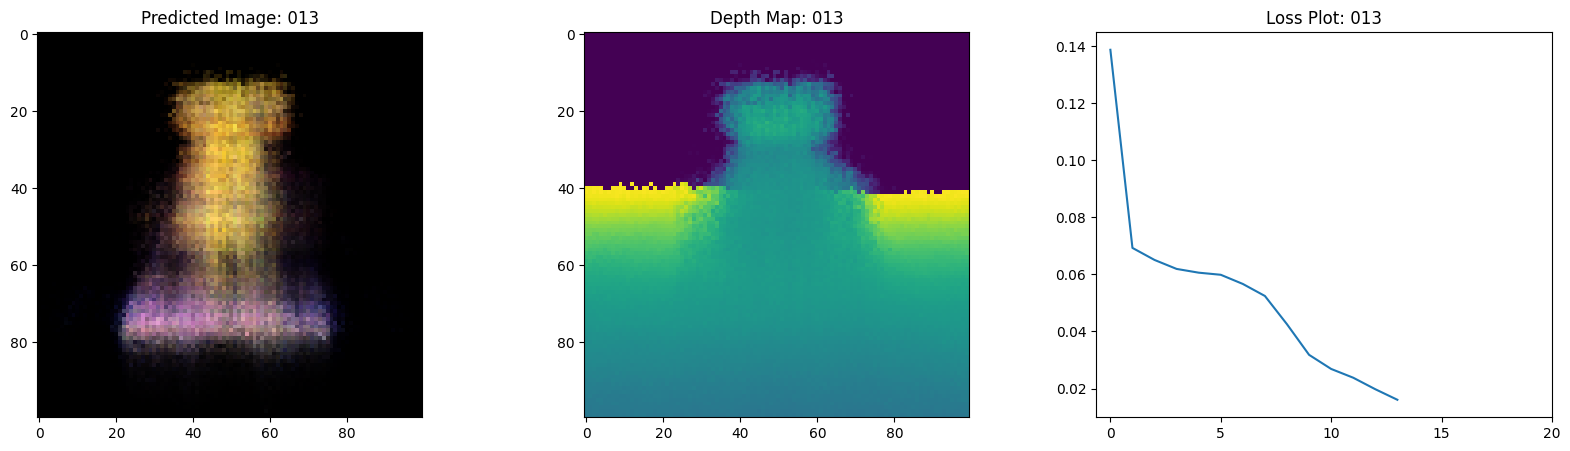

16/16 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - loss: 0.0166 - psnr: 17.9854 - val_loss: 0.0154 - val_psnr: 18.1990
Epoch 15/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 701ms/step


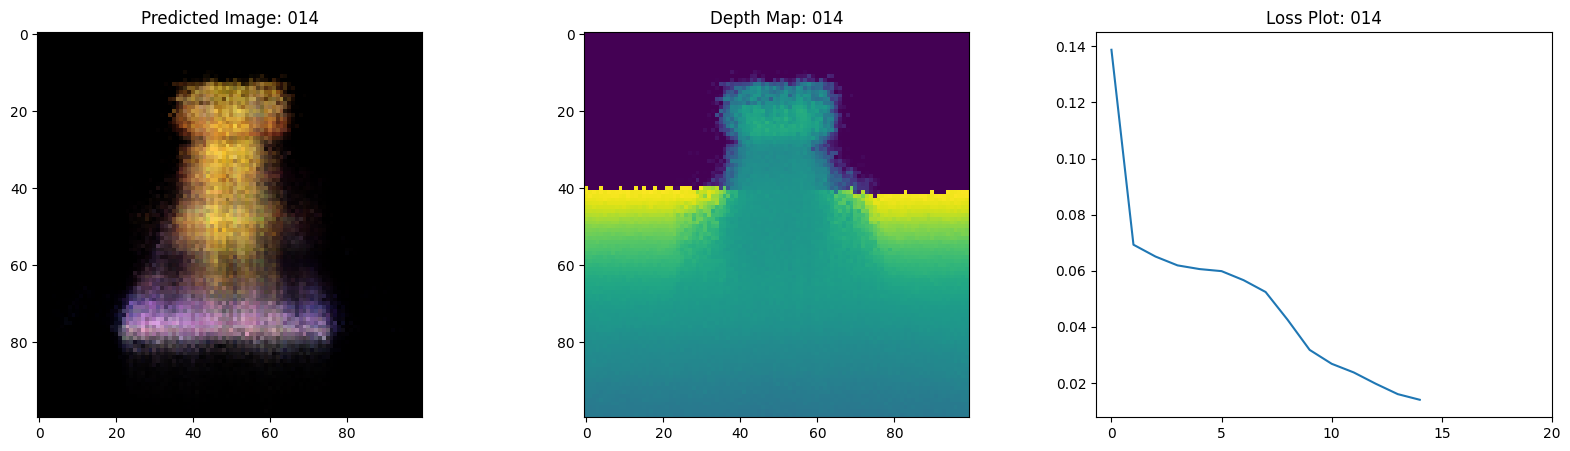

16/16 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - loss: 0.0143 - psnr: 18.6100 - val_loss: 0.0139 - val_psnr: 18.6533
Epoch 16/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 918ms/step


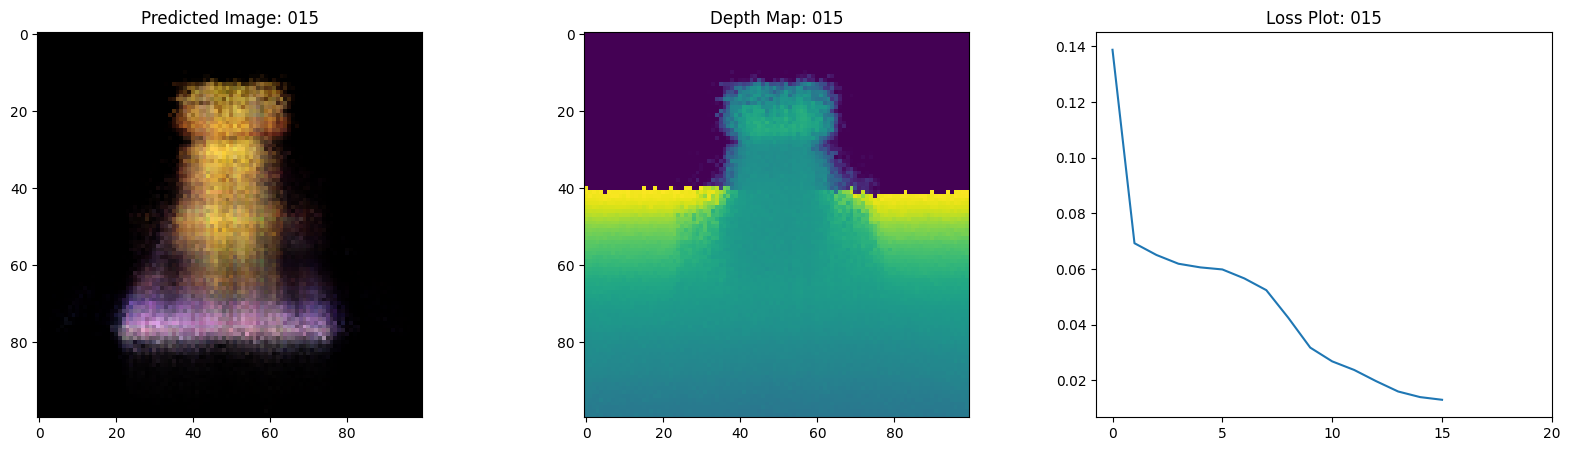

16/16 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - loss: 0.0130 - psnr: 19.0335 - val_loss: 0.0128 - val_psnr: 19.0228
Epoch 17/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step


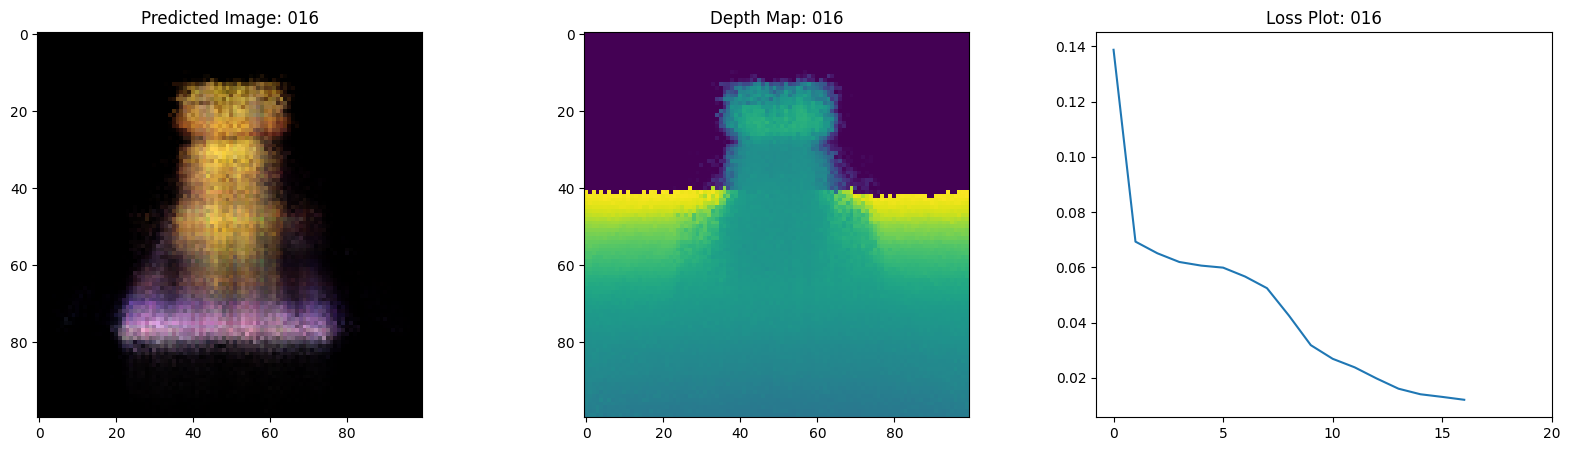

16/16 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - loss: 0.0123 - psnr: 19.3169 - val_loss: 0.0119 - val_psnr: 19.3997
Epoch 18/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 723ms/step


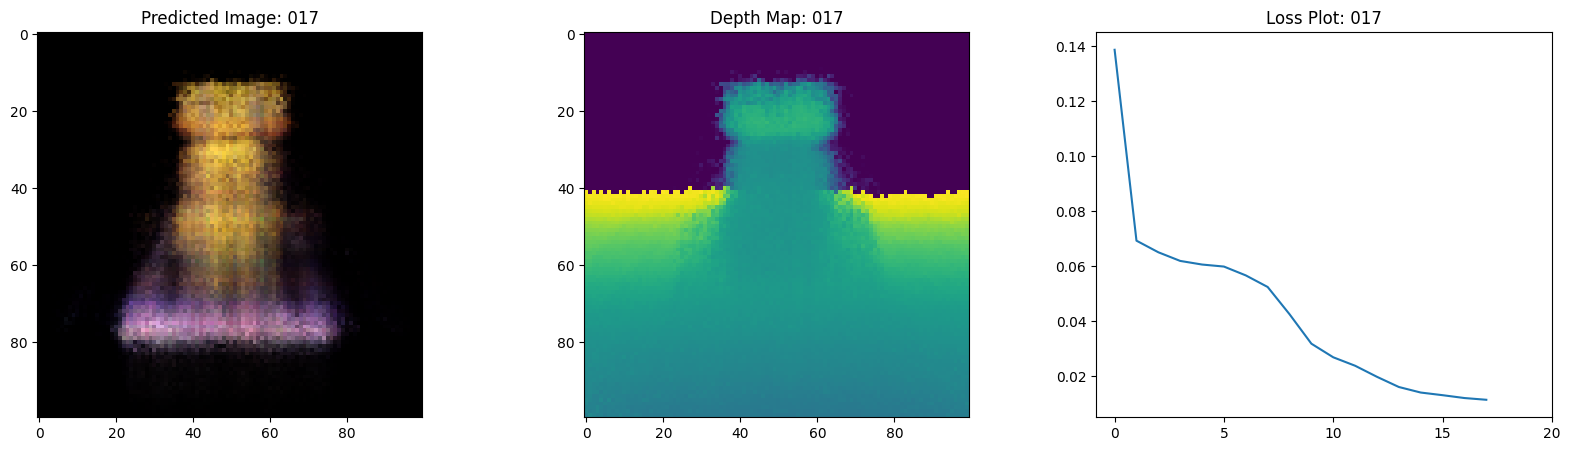

16/16 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - loss: 0.0113 - psnr: 19.6555 - val_loss: 0.0115 - val_psnr: 19.5201
Epoch 19/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 737ms/step


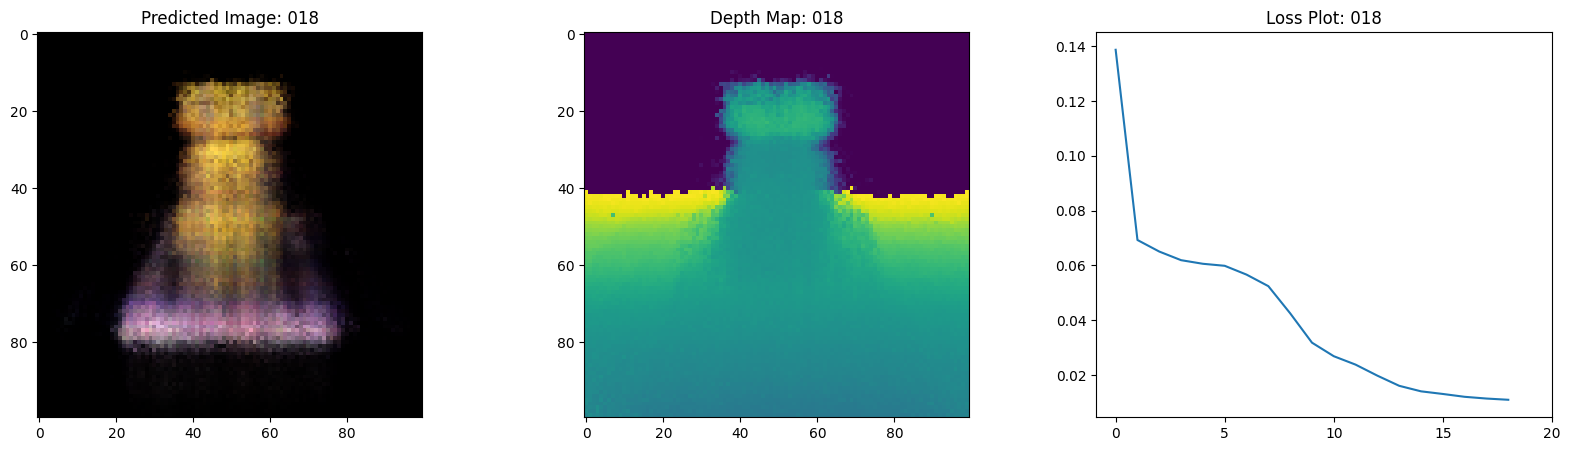

16/16 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - loss: 0.0111 - psnr: 19.7331 - val_loss: 0.0113 - val_psnr: 19.5462
Epoch 20/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 675ms/step


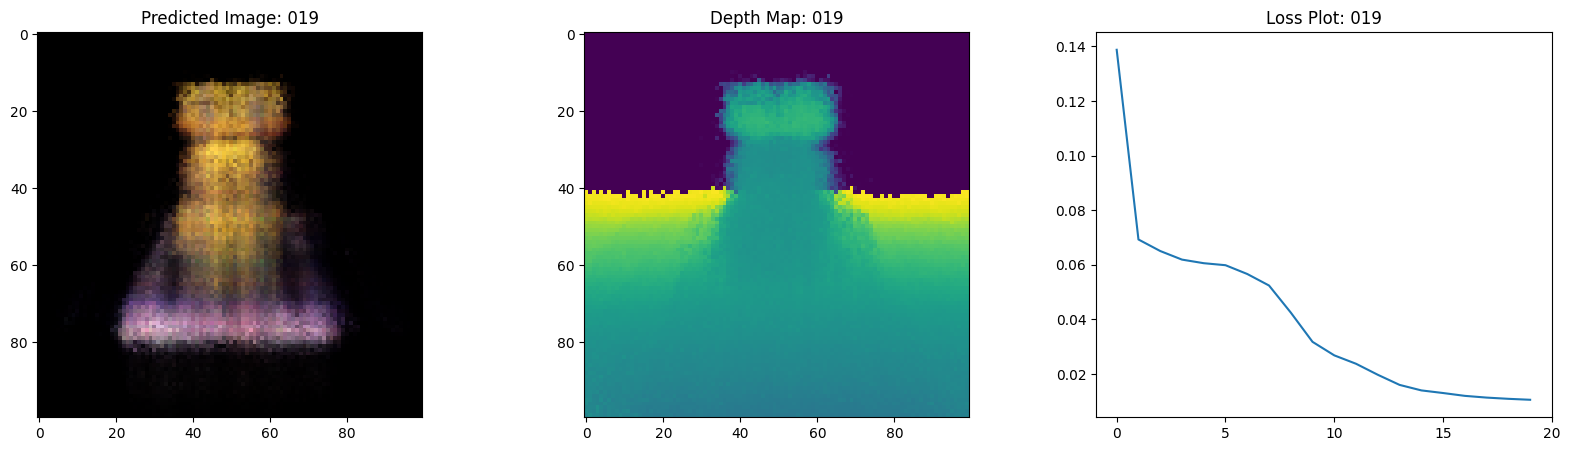

16/16 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - loss: 0.0108 - psnr: 19.8484 - val_loss: 0.0108 - val_psnr: 19.7316


100%|██████████| 20/20 [00:00<00:00, 53.36it/s]


In [5]:

class NeRF(keras.Model):
    def __init__(self, nerf_model):
        super().__init__()
        self.nerf_model = nerf_model

    def compile(self, optimizer, loss_fn):
        super().compile()
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.psnr_metric = keras.metrics.Mean(name="psnr")

    def train_step(self, inputs):
        # Get the images and the rays.
        (images, rays) = inputs
        rays_flat, rays_dirs, t_vals = rays
        print(rays_dirs.shape)

        with tf.GradientTape() as tape:
            # Get the predictions from the model.
            rgb, _ = render_rgb_depth(
                model=self.nerf_model, rays_flat=rays_flat, rays_dirs=rays_dirs, t_vals=t_vals, rand=True
            )
            loss = self.loss_fn(images, rgb)

        # Get the trainable variables.
        trainable_variables = self.nerf_model.trainable_variables

        # Get the gradeints of the trainiable variables with respect to the loss.
        gradients = tape.gradient(loss, trainable_variables)

        # Apply the grads and optimize the model.
        self.optimizer.apply_gradients(zip(gradients, trainable_variables))

        # Get the PSNR of the reconstructed images and the source images.
        psnr = tf.image.psnr(images, rgb, max_val=1.0)

        # Compute our own metrics
        self.loss_tracker.update_state(loss)
        self.psnr_metric.update_state(psnr)
        return {"loss": self.loss_tracker.result(), "psnr": self.psnr_metric.result()}

    def test_step(self, inputs):
        # Get the images and the rays.
        (images, rays) = inputs
        (rays_flat, rays_dirs, t_vals) = rays

        # Get the predictions from the model.
        rgb, _ = render_rgb_depth(
            model=self.nerf_model, rays_flat=rays_flat, rays_dirs=rays_dirs, t_vals=t_vals, rand=True
        )
        loss = self.loss_fn(images, rgb)

        # Get the PSNR of the reconstructed images and the source images.
        psnr = tf.image.psnr(images, rgb, max_val=1.0)

        # Compute our own metrics
        self.loss_tracker.update_state(loss)
        self.psnr_metric.update_state(psnr)
        return {"loss": self.loss_tracker.result(), "psnr": self.psnr_metric.result()}

    @property
    def metrics(self):
        return [self.loss_tracker, self.psnr_metric]


test_imgs, test_rays = next(iter(train_ds))
test_rays_flat, test_ray_directions, test_t_vals = test_rays


loss_list = []


class TrainMonitor(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        loss = logs["loss"]
        loss_list.append(loss)
        test_recons_images, depth_maps = render_rgb_depth(
            model=self.model.nerf_model,
            rays_flat=test_rays_flat,
            rays_dirs=test_ray_directions,
            t_vals=test_t_vals,
            rand=True,
            train=False,
        )

        # Plot the rgb, depth and the loss plot.
        fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
        ax[0].imshow(keras.utils.array_to_img(test_recons_images[0]))
        ax[0].set_title(f"Predicted Image: {epoch:03d}")

        ax[1].imshow(keras.utils.array_to_img(depth_maps[0, ..., None]))
        ax[1].set_title(f"Depth Map: {epoch:03d}")

        ax[2].plot(loss_list)
        ax[2].set_xticks(np.arange(0, EPOCHS + 1, 5.0))
        ax[2].set_title(f"Loss Plot: {epoch:03d}")

        fig.savefig(f"images/{epoch:03d}.png")
        plt.show()
        plt.close()


num_pos = H * W * NUM_SAMPLES
nerf_model = get_nerf_model(num_layers=8, num_pos=num_pos)

model = NeRF(nerf_model)
model.compile(
    optimizer=keras.optimizers.Adam(), loss_fn=keras.losses.MeanSquaredError()
)

# Create a directory to save the images during training.
if not os.path.exists("images"):
    os.makedirs("images")

model.fit(
    train_ds,
    validation_data=val_ds,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[TrainMonitor()],
)


def create_gif(path_to_images, name_gif):
    filenames = glob.glob(path_to_images)
    filenames = sorted(filenames)
    images = []
    for filename in tqdm(filenames):
        images.append(imageio.imread(filename))
    kargs = {"duration": 0.25}
    imageio.mimsave(name_gif, images, "GIF", **kargs)

# 52800000
# 6400000
create_gif("images/*.png", "training.gif")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 721ms/step


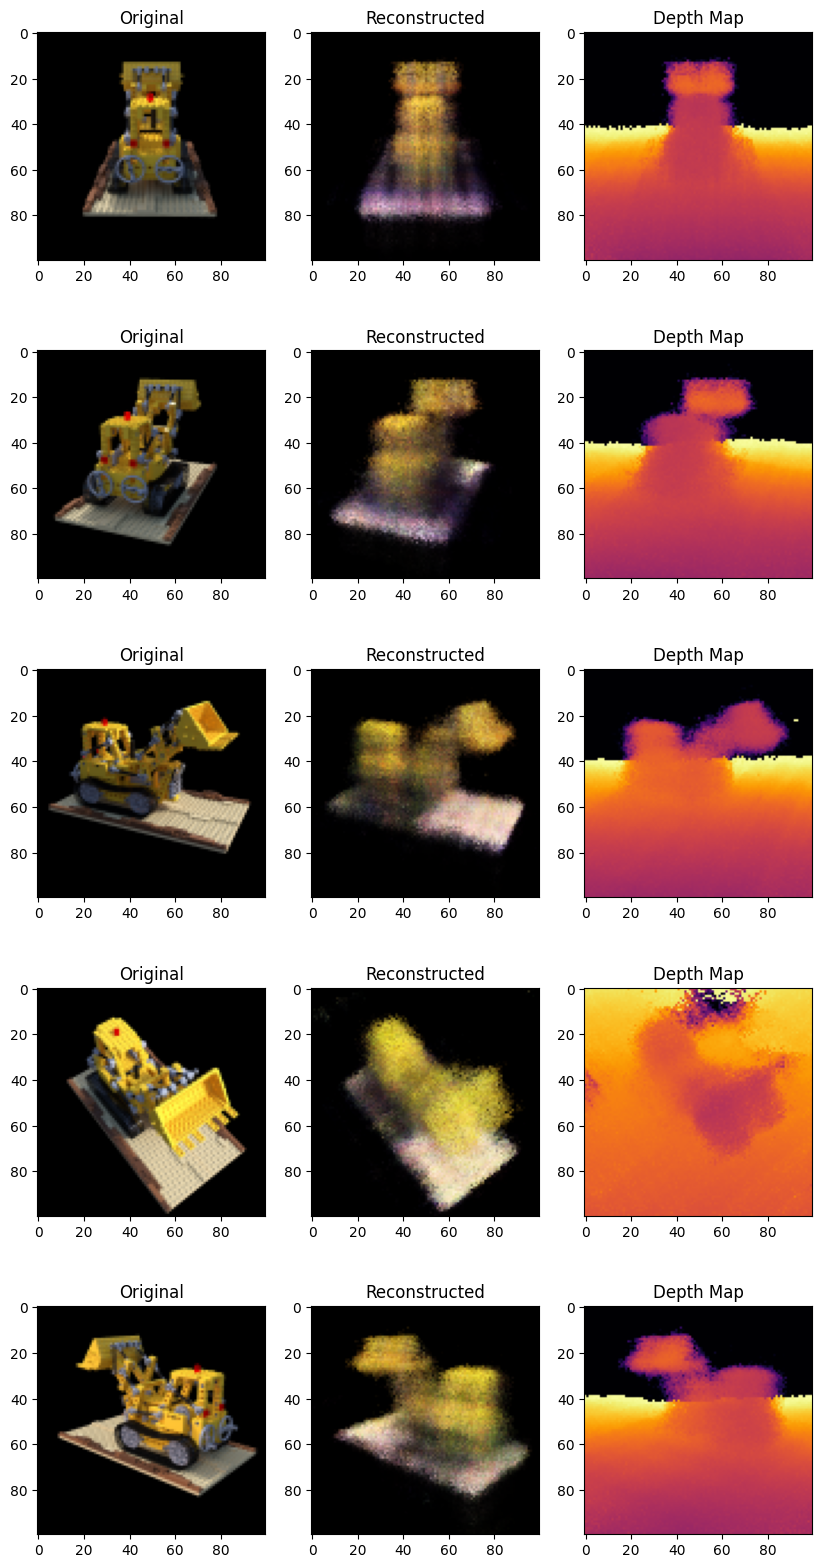

In [6]:
# Get the trained NeRF model and infer.
nerf_model = model.nerf_model
test_recons_images, depth_maps = render_rgb_depth(
    model=nerf_model,
    rays_flat=test_rays_flat,
    rays_dirs=test_ray_directions,
    t_vals=test_t_vals,
    rand=True,
    train=False,
)

# Create subplots.
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(10, 20))

for ax, ori_img, recons_img, depth_map in zip(
    axes, test_imgs, test_recons_images, depth_maps
):
    ax[0].imshow(keras.utils.array_to_img(ori_img))
    ax[0].set_title("Original")

    ax[1].imshow(keras.utils.array_to_img(recons_img))
    ax[1].set_title("Reconstructed")

    ax[2].imshow(keras.utils.array_to_img(depth_map[..., None]), cmap="inferno")
    ax[2].set_title("Depth Map")

## Render 3D Scene

Here we will synthesize novel 3D views and stitch all of them together
to render a video encompassing the 360-degree view.

In [ ]:

def get_translation_t(t):
    """Get the translation matrix for movement in t."""
    matrix = [
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, t],
        [0, 0, 0, 1],
    ]
    return tf.convert_to_tensor(matrix, dtype=tf.float32)


def get_rotation_phi(phi):
    """Get the rotation matrix for movement in phi."""
    matrix = [
        [1, 0, 0, 0],
        [0, tf.cos(phi), -tf.sin(phi), 0],
        [0, tf.sin(phi), tf.cos(phi), 0],
        [0, 0, 0, 1],
    ]
    return tf.convert_to_tensor(matrix, dtype=tf.float32)


def get_rotation_theta(theta):
    """Get the rotation matrix for movement in theta."""
    matrix = [
        [tf.cos(theta), 0, -tf.sin(theta), 0],
        [0, 1, 0, 0],
        [tf.sin(theta), 0, tf.cos(theta), 0],
        [0, 0, 0, 1],
    ]
    return tf.convert_to_tensor(matrix, dtype=tf.float32)


def pose_spherical(theta, phi, t):
    """
    Get the camera to world matrix for the corresponding theta, phi
    and t.
    """
    c2w = get_translation_t(t)
    c2w = get_rotation_phi(phi / 180.0 * np.pi) @ c2w
    c2w = get_rotation_theta(theta / 180.0 * np.pi) @ c2w
    c2w = np.array([[-1, 0, 0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 0, 1]]) @ c2w
    return c2w


rgb_frames = []
batch_flat = []
batch_t = []

# Iterate over different theta value and generate scenes.
for index, theta in tqdm(enumerate(np.linspace(0.0, 360.0, 120, endpoint=False))):
    # Get the camera to world matrix.
    c2w = pose_spherical(theta, -30.0, 4.0)

    #
    ray_oris, ray_dirs = get_rays(H, W, focal, c2w)
    rays_flat, t_vals = render_flat_rays(
        ray_oris, ray_dirs, near=2.0, far=6.0, num_samples=NUM_SAMPLES, rand=False
    )

    if index % BATCH_SIZE == 0 and index > 0:
        batched_flat = tf.stack(batch_flat, axis=0)
        batch_flat = [rays_flat]

        batched_t = tf.stack(batch_t, axis=0)
        batch_t = [t_vals]

        rgb, _ = render_rgb_depth(
            nerf_model, batched_flat, batched_t, rand=False, train=False
        )

        temp_rgb = [np.clip(255 * img, 0.0, 255.0).astype(np.uint8) for img in rgb]

        rgb_frames = rgb_frames + temp_rgb
    else:
        batch_flat.append(rays_flat)
        batch_t.append(t_vals)

rgb_video = "rgb_video.mp4"
imageio.mimwrite(rgb_video, rgb_frames, fps=30, quality=7, macro_block_size=None)

0it [00:00, ?it/s]

(100, 100, 3) (100, 100, 3)


5it [00:01,  3.42it/s]

rays shape before reshape : (100, 100, 32, 3)
rays shape after reshape : (320000, 3)
rays shape after pos encode : (320000, 63)
(100, 100, 3) (100, 100, 3)
rays shape before reshape : (100, 100, 32, 3)
rays shape after reshape : (320000, 3)
rays shape after pos encode : (320000, 63)
(100, 100, 3) (100, 100, 3)
rays shape before reshape : (100, 100, 32, 3)
rays shape after reshape : (320000, 3)
rays shape after pos encode : (320000, 63)
(100, 100, 3) (100, 100, 3)
rays shape before reshape : (100, 100, 32, 3)
rays shape after reshape : (320000, 3)
rays shape after pos encode : (320000, 63)
(100, 100, 3) (100, 100, 3)
rays shape before reshape : (100, 100, 32, 3)
rays shape after reshape : (320000, 3)
rays shape after pos encode : (320000, 63)
(100, 100, 3) (100, 100, 3)
rays shape before reshape : (100, 100, 32, 3)
rays shape after reshape : (320000, 3)
rays shape after pos encode : (320000, 63)


TypeError: render_rgb_depth() missing 1 required positional argument: 't_vals'